In [2]:
import exploretinyrm as m
print(m.__version__)

%load_ext autoreload
%autoreload 2

import torch
from exploretinyrm.utils import compute_tensor_summary  


0.1.0


In [33]:

import os, math, random
from dataclasses import dataclass
from typing import Tuple
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader


import sys
sys.path.append("src")

from exploretinyrm.trm import TRM, TRMConfig

def set_seed(seed: int = 123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [11]:
from pathlib import Path
import os, json, random
import matplotlib.pyplot as plt

from tsp_data_gen import (
    write_dataset,
    demo_once,
    dataset_stats,
    show_examples,
    pairwise_euclidean,
    tour_length
)

output_dir = Path("data")
output_dir.mkdir(exist_ok=True)
output_path = str(output_dir / "tsp_train_small.jsonl")


In [5]:
demo_once(n=10, seed=42, noise_k=3)

Demo TSP with n=10, seed=42
City coordinates (index: x y):
   0: 0.3745 0.9507
   1: 0.7320 0.5987
   2: 0.1560 0.1560
   3: 0.0581 0.8662
   4: 0.6011 0.7081
   5: 0.0206 0.9699
   6: 0.8324 0.2123
   7: 0.1818 0.1834
   8: 0.3042 0.5248
   9: 0.4319 0.2912

Cheapest Insertion trajectory:
  step  0: insert city 3 at position 3; len 2.6143 -> 2.6164 (delta +0.0021)
    partial tour: [5, 6, 2]
  step  1: insert city 7 at position 2; len 2.6164 -> 2.6265 (delta +0.0101)
    partial tour: [5, 6, 2, 3]
  step  2: insert city 9 at position 2; len 2.6265 -> 2.6558 (delta +0.0293)
    partial tour: [5, 6, 7, 2, 3]
  step  3: insert city 8 at position 1; len 2.6558 -> 2.6869 (delta +0.0311)
    partial tour: [5, 6, 9, 7, 2, 3]
  step  4: insert city 1 at position 2; len 2.6869 -> 2.9065 (delta +0.2196)
    partial tour: [5, 8, 6, 9, 7, 2, 3]
  step  5: insert city 4 at position 2; len 2.9065 -> 2.9919 (delta +0.0854)
    partial tour: [5, 8, 1, 6, 9, 7, 2, 3]
  step  6: insert city 0 at positi

In [7]:
number_of_problems = 800       # total problems to sample
n_min, n_max = 6, 12           # instance size range
prob_constructive = 0.8         # mix of constructive vs improvement samples
insert_steps_per_problem = 6    # number of mid-trajectory insert snapshots per problem
two_opt_steps_per_problem = 4   # number of mid-trajectory 2-opt snapshots per problem
step_sampling = "mid"           # "uniform" | "early" | "mid" | "late" | "all"
noise_min, noise_max = 2, 4     # random 2-opt noise before improvement trajectory
include_stop_probability = 0.20 # occasionally include a STOP example

In [8]:

write_dataset(
    out_path=output_path,
    num_problems=number_of_problems,
    n_min=n_min,
    n_max=n_max,
    seed=1234,
    p_constructive=prob_constructive,
    ins_per=insert_steps_per_problem,
    opt_per=two_opt_steps_per_problem,
    step_sample=step_sampling,
    noise_min=noise_min,
    noise_max=noise_max,
    include_stop_prob=include_stop_probability
)

print("Wrote:", output_path)

Wrote: data/tsp_train_small.jsonl


In [9]:
show_examples(output_path, k=5)

Showing 5 examples from 2089 lines:

----------------------------
line 214: mode=insert n=10 step=3/7 teacher=cheapest_insertion
tour_partial: [0, 1, 6, 7, 5, 3]
action: insert city 9 at position 3
cost_before -> cost_after: 2.3462 -> 2.3522

----------------------------
line 357: mode=insert n=12 step=5/9 teacher=cheapest_insertion
tour_partial: [5, 0, 1, 6, 4, 8, 10, 7]
action: insert city 3 at position 6
cost_before -> cost_after: 2.6975 -> 2.7662

----------------------------
line 1091: mode=insert n=12 step=5/9 teacher=cheapest_insertion
tour_partial: [0, 2, 6, 4, 8, 7, 5, 10]
action: insert city 3 at position 2
cost_before -> cost_after: 2.5198 -> 2.5776

----------------------------
line 1096: mode=insert n=11 step=2/8 teacher=cheapest_insertion
tour_partial: [7, 6, 10, 0, 9]
action: insert city 2 at position 1
cost_before -> cost_after: 2.5911 -> 2.5964

----------------------------
line 1668: mode=two_opt n=11 step=1/4 teacher=two_opt_best
action: 2-opt (i=4, j=7)
tour_full: [

In [10]:
dataset_stats(output_path)

Lines read: 2089
Mode counts: {'insert': 1089, 'two_opt': 1000}
n: min=6 max=12 mean=9.43
step_index/total_steps: mean=0.331 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.1170


In [12]:


def plot_insert_example(example: dict, figsize=(5,5)):
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    tour_partial = example["tour_partial"]
    action_city = example["action"]["city"]
    insert_position = example["action"]["position"]
    m = len(tour_partial)

    plt.figure(figsize=figsize)
    plt.scatter(coords[:, 0], coords[:, 1], s=40)
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(idx), ha="center", va="bottom")

    # Draw partial tour cycle
    for k in range(m):
        a = tour_partial[k]
        b = tour_partial[(k + 1) % m]
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]])

    # Highlight the insertion edge that will be split
    u = tour_partial[(insert_position - 1) % m]
    v = tour_partial[(insert_position) % m]
    plt.plot([coords[u, 0], coords[v, 0]], [coords[u, 1], coords[v, 1]], linestyle="--", linewidth=2)

    # Highlight the city to insert
    plt.scatter([coords[action_city, 0]], [coords[action_city, 1]], s=110, marker="s")

    title = f"Insert step: city {action_city} at position {insert_position}\n" \
            f"cost {example['cost_before']:.4f} -> {example['cost_after']:.4f}"
    plt.title(title)
    plt.axis("equal")
    plt.show()


def plot_two_opt_example(example: dict, figsize=(5,5)):
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    tour_full = example["tour_full"]

    plt.figure(figsize=figsize)
    plt.scatter(coords[:, 0], coords[:, 1], s=40)
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(idx), ha="center", va="bottom")

    # Draw entire tour
    n = len(tour_full)
    for k in range(n):
        a = tour_full[k]
        b = tour_full[(k + 1) % n]
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]])

    action = example["action"]
    if not action.get("stop", False):
        i = action["i"]
        j = action["j"]
        a = tour_full[i - 1]; b = tour_full[i]
        c = tour_full[j];     d = tour_full[(j + 1) % n]
        # Emphasize the two edges that will be replaced by the 2-opt swap
        plt.plot([coords[a, 0], coords[b, 0]], [coords[a, 1], coords[b, 1]], linewidth=3)
        plt.plot([coords[c, 0], coords[d, 0]], [coords[c, 1], coords[d, 1]], linewidth=3)
        title = f"2-opt step: (i={i}, j={j})  cost {example['cost_before']:.4f} -> {example['cost_after']:.4f}"
    else:
        title = f"2-opt STOP at cost {example['cost_before']:.4f}"

    plt.title(title)
    plt.axis("equal")
    plt.show()



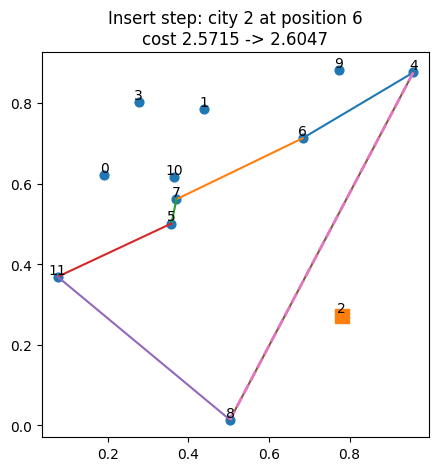

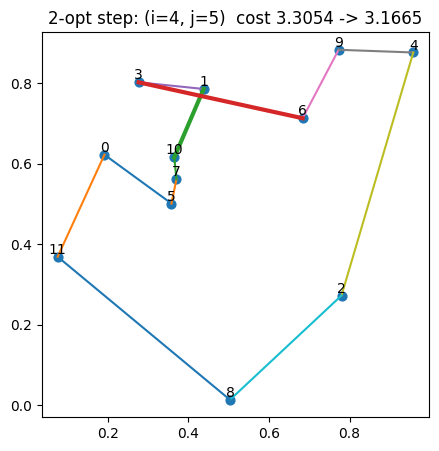

In [13]:

with open(output_path, "r") as f:
    lines = [json.loads(line) for _, line in zip(range(5000), f)]  # adjust cap as needed

insert_example = next(ex for ex in lines if ex["mode"] == "insert")
two_opt_example = next(ex for ex in lines if ex["mode"] == "two_opt" and not ex["action"].get("stop", False))


plot_insert_example(insert_example)

plot_two_opt_example(two_opt_example)



In [ ]:


def verify_insert(example: dict) -> bool:
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour_before = example["tour_partial"]
    city = example["action"]["city"]
    position = example["action"]["position"]
    tour_after = tour_before[:position] + [city] + tour_before[position:]
    computed_before = tour_length(dist, tour_before)
    computed_after = tour_length(dist, tour_after)
    ok = (abs(computed_before - example["cost_before"]) < 1e-5) and (abs(computed_after - example["cost_after"]) < 1e-5)
    return bool(ok)


def verify_two_opt(example: dict) -> bool:
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour_before = example["tour_full"]
    computed_before = tour_length(dist, tour_before)
    if example["action"].get("stop", False):
        # At STOP we only check that the stored cost matches the tour_before cost
        return abs(computed_before - example["cost_before"]) < 1e-5
    i = example["action"]["i"]
    j = example["action"]["j"]
    # Apply the 2-opt swap and recompute
    def two_opt_swap_py(tour, i, j):
        return tour[:i] + list(reversed(tour[i:j+1])) + tour[j+1:]
    tour_after = two_opt_swap_py(tour_before, i, j)
    computed_after = tour_length(dist, tour_after)
    ok1 = abs(computed_before - example["cost_before"]) < 1e-5
    ok2 = abs(computed_after - example["cost_after"]) < 1e-5
    return bool(ok1 and ok2)


# Run a quick check over a handful of samples
sampled = random.sample(lines, k=min(20, len(lines)))
results = []
for ex in sampled:
    if ex["mode"] == "insert":
        results.append(verify_insert(ex))
    else:
        results.append(verify_two_opt(ex))

print("Integrity check pass rate over sample:", sum(results), "/", len(results))



Integrity check pass rate over sample: 20 / 20


In [15]:

# Verify that the recorded insert is truly the cheapest among all city-position pairs
def verify_insert_is_cheapest(example):
    assert example["mode"] == "insert"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_partial"]
    chosen_city = example["action"]["city"]
    chosen_pos  = example["action"]["position"]
    n = coords.shape[0]
    visited = set(tour)

    def delta(u, c, v): return float(dist[u, c] + dist[c, v] - dist[u, v])

    best = float("inf"); best_pair = None
    m = len(tour)
    for c in range(n):
        if c in visited:
            continue
        for pos in range(m):
            u, v = tour[pos], tour[(pos + 1) % m]
            d = delta(u, c, v)
            if d < best:
                best = d; best_pair = (c, pos + 1)
    return (chosen_city, chosen_pos) == best_pair


# Verify that the recorded 2-opt move is the best improvement available
def verify_two_opt_is_best(example):
    assert example["mode"] == "two_opt"
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_full"]
    n = len(tour)

    best_delta = 0.0; best_pair = (None, None)
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            delta = float(dist[a, c]) + float(dist[b, d]) - float(dist[a, b]) - float(dist[c, d])
            if delta < best_delta - 1e-12:
                best_delta = delta; best_pair = (i, j)

    if example["action"].get("stop", False):
        # No improving move should exist
        return best_pair == (None, None)
    else:
        return (example["action"]["i"], example["action"]["j"]) == best_pair


In [16]:
from tsp_data_gen import pairwise_euclidean  # make sure this import works

DATA_PATH = "data/tsp_train_small.jsonl"  # adjust if needed

# Load a few lines
with open(DATA_PATH, "r") as f:
    rows = [json.loads(line) for _, line in zip(range(5000), f)]

insert_ex = next(ex for ex in rows if ex["mode"] == "insert")
twoopt_ex = next(ex for ex in rows if ex["mode"] == "two_opt" and not ex["action"].get("stop", False))

print("Insert example cheapest? ", verify_insert_is_cheapest(insert_ex))
print("Two-opt example best?    ", verify_two_opt_is_best(twoopt_ex))


Insert example cheapest?  True
Two-opt example best?     True


In [17]:
rng = random.Random(0)
sample_size = min(300, len(rows))  # tune up or down
indices = sorted(rng.sample(range(len(rows)), k=sample_size))

insert_pass = insert_total = 0
twoopt_pass = twoopt_total = 0

for idx in indices:
    ex = rows[idx]
    if ex["mode"] == "insert":
        insert_total += 1
        insert_pass  += int(verify_insert_is_cheapest(ex))
    else:
        twoopt_total += 1
        twoopt_pass  += int(verify_two_opt_is_best(ex))

print(f"Insert:  {insert_pass}/{insert_total} passed")
print(f"Two-opt: {twoopt_pass}/{twoopt_total} passed")
print(f"Overall: {(insert_pass + twoopt_pass)}/{(insert_total + twoopt_total)} passed")


Insert:  152/152 passed
Two-opt: 148/148 passed
Overall: 300/300 passed


In [18]:
def explain_insert_failure(example):
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_partial"]
    chosen_city = example["action"]["city"]
    chosen_pos  = example["action"]["position"]
    n = coords.shape[0]
    visited = set(tour)
    m = len(tour)

    def delta(u, c, v): return float(dist[u, c] + dist[c, v] - dist[u, v])

    best = float("inf"); best_pair = None; chosen_delta = None
    for c in range(n):
        if c in visited:
            continue
        for pos in range(m):
            u, v = tour[pos], tour[(pos + 1) % m]
            d = delta(u, c, v)
            if c == chosen_city and (pos + 1) == chosen_pos:
                chosen_delta = d
            if d < best:
                best = d; best_pair = (c, pos + 1)
    print("Insert failure:")
    print("  chosen (city, pos):", (chosen_city, chosen_pos), "delta:", chosen_delta)
    print("  best   (city, pos):", best_pair, "delta:", best)

def explain_two_opt_failure(example):
    coords = np.array(example["coords"], dtype=np.float32)
    dist = pairwise_euclidean(coords)
    tour = example["tour_full"]
    n = len(tour)

    best_delta = 0.0; best_pair = (None, None)
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            delta = float(dist[a, c]) + float(dist[b, d]) - float(dist[a, b]) - float(dist[c, d])
            if delta < best_delta - 1e-12:
                best_delta = delta; best_pair = (i, j)

    if example["action"].get("stop", False):
        print("Two-opt STOP failure: should have no improving move.")
        print("  best available delta:", best_delta, "pair:", best_pair)
    else:
        i0, j0 = example["action"]["i"], example["action"]["j"]
        print("Two-opt failure:")
        print("  chosen (i, j):", (i0, j0))
        print("  best   (i, j):", best_pair, "best delta:", best_delta)

# Stream the file and check
insert_pass = insert_total = 0
twoopt_pass = twoopt_total = 0
fail_show = 0
max_fail_show = 3

with open(DATA_PATH, "r") as f:
    for line in f:
        ex = json.loads(line)
        if ex["mode"] == "insert":
            insert_total += 1
            ok = verify_insert_is_cheapest(ex)
            insert_pass += int(ok)
            if not ok and fail_show < max_fail_show:
                explain_insert_failure(ex); fail_show += 1
        else:
            twoopt_total += 1
            ok = verify_two_opt_is_best(ex)
            twoopt_pass += int(ok)
            if not ok and fail_show < max_fail_show:
                explain_two_opt_failure(ex); fail_show += 1

print(f"\nInsert:  {insert_pass}/{insert_total} passed")
print(f"Two-opt: {twoopt_pass}/{twoopt_total} passed")
print(f"Overall: {(insert_pass + twoopt_pass)}/{(insert_total + twoopt_total)} passed")



Insert:  1089/1089 passed
Two-opt: 1000/1000 passed
Overall: 2089/2089 passed


In [19]:
# collect first failing examples for each mode
first_bad_insert = None
first_bad_twoopt = None

for ex in rows:
    if ex["mode"] == "insert" and not verify_insert_is_cheapest(ex) and first_bad_insert is None:
        first_bad_insert = ex
    if ex["mode"] == "two_opt" and not verify_two_opt_is_best(ex) and first_bad_twoopt is None:
        first_bad_twoopt = ex
    if first_bad_insert and first_bad_twoopt:
        break

if first_bad_insert:
    plot_insert_example(first_bad_insert)
if first_bad_twoopt:
    plot_two_opt_example(first_bad_twoopt)

if not first_bad_insert and not first_bad_twoopt:
    print("No failures found in the loaded rows.")


No failures found in the loaded rows.


In [25]:

DATA_PATH = "data/tsp_train_small.jsonl"   
BATCH_SIZE = 64

In [26]:
def load_jsonl_split(path):
    insert_list = []
    two_opt_list = []
    with open(path, "r") as f:
        for line in f:
            ex = json.loads(line)
            if ex["mode"] == "insert":
                tp = np.array(ex["tour_partial"], dtype=np.int64)  # [m]
                m = int(tp.shape[0])
                pos_raw = int(ex["action"]["position"])            # JSONL stores 1..m
                pos_edge = (pos_raw - 1) % m                       # map to 0..m-1

                insert_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),  # [n,2]
                    "tour_partial": tp,                                  # [m]
                    "target_city": int(ex["action"]["city"]),
                    "target_position": int(pos_edge)                     # 0..m-1 for classifier
                })
            else:
                act = ex["action"]
                stop = bool(act.get("stop", False))
                target_i = -1 if stop else int(act["i"])
                target_j = -1 if stop else int(act["j"])
                two_opt_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),     # [n,2]
                    "tour_full": np.array(ex["tour_full"], dtype=np.int64), # [n]
                    "stop": stop,
                    "target_i": target_i,
                    "target_j": target_j
                })
    return insert_list, two_opt_list

insert_examples, two_opt_examples = load_jsonl_split(DATA_PATH)
print(f"Loaded: insert={len(insert_examples)}  two_opt={len(two_opt_examples)}")



Loaded: insert=1089  two_opt=1000


In [27]:
class InsertDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collate_insert(batch):
    batch_size = len(batch)
    n_max = max(item["coords"].shape[0] for item in batch)
    m_max = max(item["tour_partial"].shape[0] for item in batch)

    coords = torch.zeros(batch_size, n_max, 2, dtype=torch.float32)
    visited_mask = torch.zeros(batch_size, n_max, dtype=torch.float32)
    partial_tour = torch.full((batch_size, m_max), -1, dtype=torch.long)
    partial_length = torch.zeros(batch_size, dtype=torch.long)
    target_city = torch.zeros(batch_size, dtype=torch.long)
    target_position = torch.zeros(batch_size, dtype=torch.long)

    for b, item in enumerate(batch):
        n = item["coords"].shape[0]
        m = item["tour_partial"].shape[0]
        coords[b, :n] = torch.from_numpy(item["coords"])
        partial_tour[b, :m] = torch.from_numpy(item["tour_partial"])
        partial_length[b] = m
        target_city[b] = item["target_city"]
        target_position[b] = item["target_position"]
        # build visited mask from the partial tour
        for v in item["tour_partial"]:
            visited_mask[b, int(v)] = 1.0

    return {
        "coords": coords,                         # [B, Nmax, 2]
        "visited_mask": visited_mask,             # [B, Nmax] 1=visited
        "partial_tour": partial_tour,             # [B, Mmax] with -1 pad
        "partial_length": partial_length,         # [B]
        "target_city": target_city,               # [B]
        "target_position": target_position        # [B]
    }

class TwoOptDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def enumerate_two_opt_pairs(tour):
    # valid 2-opt pairs under standard adjacency constraints
    n = len(tour)
    pairs = []
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            pairs.append((i, j))
    return pairs

def collate_two_opt_pairclass(batch):
    # Build a per-sample catalogue of candidate pairs and target index, with a STOP class
    batch_size = len(batch)
    n_max = max(item["coords"].shape[0] for item in batch)

    coords = torch.zeros(batch_size, n_max, 2, dtype=torch.float32)
    tour_full = torch.full((batch_size, n_max), -1, dtype=torch.long)
    n_nodes = torch.zeros(batch_size, dtype=torch.long)

    candidate_lists = []
    target_indices = []
    for b, item in enumerate(batch):
        n = item["coords"].shape[0]
        coords[b, :n] = torch.from_numpy(item["coords"])
        tour_full[b, :n] = torch.from_numpy(item["tour_full"])
        n_nodes[b] = n

        pairs = enumerate_two_opt_pairs(item["tour_full"].tolist())
        pair_to_index = {p: k for k, p in enumerate(pairs)}
        if item["stop"]:
            target_idx = len(pairs)  # STOP class at the end
        else:
            target_idx = pair_to_index[(item["target_i"], item["target_j"])]
        candidate_lists.append(pairs)
        target_indices.append(target_idx)

    # Pad the candidate pair lists and build masks
    L = max(len(pairs) + 1 for pairs in candidate_lists)  # +1 for STOP
    pair_indices = torch.full((batch_size, L, 2), -1, dtype=torch.long)  # holds (i,j)
    pair_mask = torch.zeros(batch_size, L, dtype=torch.bool)              # True where valid
    for b, pairs in enumerate(candidate_lists):
        K = len(pairs)
        if K > 0:
            pair_indices[b, :K] = torch.tensor(pairs, dtype=torch.long)
        # mark K pairs plus one STOP slot as valid classes
        pair_mask[b, :K+1] = True

    target_pair_index = torch.tensor(target_indices, dtype=torch.long)

    return {
        "coords": coords,                   # [B, Nmax, 2]
        "tour_full": tour_full,             # [B, Nmax] with -1 pad
        "n_nodes": n_nodes,                 # [B]
        "pair_indices": pair_indices,       # [B, L, 2], entries -1 are padding
        "pair_mask": pair_mask,             # [B, L], True for valid classes (K pairs + STOP)
        "target_pair_index": target_pair_index  # [B], in [0..K] where K is STOP
    }


In [28]:
insert_loader = DataLoader(
    InsertDataset(insert_examples),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_insert,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

two_opt_loader = DataLoader(
    TwoOptDataset(two_opt_examples),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

insert_batch = next(iter(insert_loader))
two_opt_batch = next(iter(two_opt_loader))

def brief_shapes(name, batch):
    print(f"\n{name}")
    for k, v in batch.items():
        if torch.is_tensor(v):
            print(f"  {k:18s} {tuple(v.shape)} {v.dtype}")
        else:
            print(f"  {k:18s} {type(v)}")

brief_shapes("Insert batch", insert_batch)
brief_shapes("Two-opt batch", two_opt_batch)

# A couple of sanity asserts you can keep
B, Nmax = insert_batch["coords"].shape[:2]
assert (insert_batch["target_city"] < Nmax).all()
assert (insert_batch["target_position"] < insert_batch["partial_length"]).all()

B2, Lmax = two_opt_batch["pair_mask"].shape
assert (two_opt_batch["target_pair_index"] < Lmax).all()



Insert batch
  coords             (64, 12, 2) torch.float32
  visited_mask       (64, 12) torch.float32
  partial_tour       (64, 8) torch.int64
  partial_length     (64,) torch.int64
  target_city        (64,) torch.int64
  target_position    (64,) torch.int64

Two-opt batch
  coords             (64, 12, 2) torch.float32
  tour_full          (64, 12) torch.int64
  n_nodes            (64,) torch.int64
  pair_indices       (64, 46, 2) torch.int64
  pair_mask          (64, 46) torch.bool
  target_pair_index  (64,) torch.int64


In [30]:
# save (unchanged)
checkpoint_path = "data/tsp_ready.pt"
payload = {
    "insert_examples": insert_examples,
    "two_opt_examples": two_opt_examples,
    "meta": {
        "source": DATA_PATH,
        "counts": {"insert": len(insert_examples), "two_opt": len(two_opt_examples)}
    }
}
torch.save(payload, checkpoint_path)
print("Saved checkpoint:", checkpoint_path)

# load with weights_only=False (explicitly allow general pickled objects)
reloaded = torch.load(checkpoint_path, weights_only=False)
print("Reloaded counts:", len(reloaded["insert_examples"]), len(reloaded["two_opt_examples"]))


Saved checkpoint: data/tsp_ready.pt
Reloaded counts: 1089 1000


In [31]:

# Minimal wrappers around tsp_data_gen.write_dataset
import os
from tsp_data_gen import write_dataset

def make_dataset_pairs_only(
    out_path: str,
    num_problems: int = 4000,
    n_min: int = 6,
    n_max: int = 12,
    seed: int = 1234,
    opt_per: int = 6,
    step_sample: str = "mid",
    noise_min: int = 2,
    noise_max: int = 4,
    include_stop_prob: float = 0.2,
) -> None:
    """
    Create a JSONL with only 2-opt steps (pairs track).
    """
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    write_dataset(
        out_path=out_path,
        num_problems=num_problems,
        n_min=n_min,
        n_max=n_max,
        seed=seed,
        p_constructive=0.0,
        ins_per=0,
        opt_per=opt_per,
        step_sample=step_sample,
        noise_min=noise_min,
        noise_max=noise_max,
        include_stop_prob=include_stop_prob,
    )

def make_dataset_mixed(
    out_path: str,
    num_problems: int = 4000,
    n_min: int = 6,
    n_max: int = 12,
    seed: int = 1234,
    p_constructive: float = 0.7,
    ins_per: int = 6,
    opt_per: int = 6,
    step_sample: str = "mid",
    noise_min: int = 2,
    noise_max: int = 4,
    include_stop_prob: float = 0.2,
) -> None:
    """
    Create a JSONL with both insert and 2-opt steps (mixed track).
    """
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    write_dataset(
        out_path=out_path,
        num_problems=num_problems,
        n_min=n_min,
        n_max=n_max,
        seed=seed,
        p_constructive=p_constructive,
        ins_per=ins_per,
        opt_per=opt_per,
        step_sample=step_sample,
        noise_min=noise_min,
        noise_max=noise_max,
        include_stop_prob=include_stop_prob,
    )



In [34]:



def load_jsonl_split(path: str) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """
    Returns (insert_examples, two_opt_examples).
    For insert_examples, maps action.position (1..m) to edge index 0..m-1.
    Each example dict stores numpy arrays for coords and tours, and ints for labels.
    """
    insert_list: List[Dict[str, Any]] = []
    two_opt_list: List[Dict[str, Any]] = []
    with open(path, "r") as f:
        for line in f:
            ex = json.loads(line)
            if ex["mode"] == "insert":
                tour_partial = np.array(ex["tour_partial"], dtype=np.int64)
                m = int(tour_partial.shape[0])
                pos_raw = int(ex["action"]["position"])   # 1..m in JSON
                pos_edge = (pos_raw - 1) % m              # 0..m-1 for classifier
                insert_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),  # [n,2]
                    "tour_partial": tour_partial,                        # [m]
                    "target_city": int(ex["action"]["city"]),
                    "target_position": int(pos_edge),
                })
            elif ex["mode"] == "two_opt":
                act = ex["action"]
                stop = bool(act.get("stop", False))
                two_opt_list.append({
                    "coords": np.array(ex["coords"], dtype=np.float32),   # [n,2]
                    "tour_full": np.array(ex["tour_full"], dtype=np.int64),  # [n]
                    "stop": stop,
                    "target_i": -1 if stop else int(act["i"]),
                    "target_j": -1 if stop else int(act["j"]),
                })
    return insert_list, two_opt_list



In [35]:

class InsertDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collate_insert(batch):
    B = len(batch)
    n_max = max(x["coords"].shape[0] for x in batch)
    m_max = max(x["tour_partial"].shape[0] for x in batch)

    coords = torch.zeros(B, n_max, 2, dtype=torch.float32)
    visited_mask = torch.zeros(B, n_max, dtype=torch.float32)
    partial_tour = torch.full((B, m_max), -1, dtype=torch.long)
    partial_length = torch.zeros(B, dtype=torch.long)
    target_city = torch.zeros(B, dtype=torch.long)
    target_position = torch.zeros(B, dtype=torch.long)

    for b, x in enumerate(batch):
        n = x["coords"].shape[0]
        m = x["tour_partial"].shape[0]
        coords[b, :n] = torch.from_numpy(x["coords"])
        partial_tour[b, :m] = torch.from_numpy(x["tour_partial"])
        partial_length[b] = m
        target_city[b] = x["target_city"]
        target_position[b] = x["target_position"]
        for v in x["tour_partial"]:
            visited_mask[b, int(v)] = 1.0

    return {
        "coords": coords,                   # [B, Nmax, 2]
        "visited_mask": visited_mask,       # [B, Nmax]
        "partial_tour": partial_tour,       # [B, Mmax]
        "partial_length": partial_length,   # [B]
        "target_city": target_city,         # [B]
        "target_position": target_position  # [B] in [0..m-1]
    }

class TwoOptDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def enumerate_two_opt_pairs(tour):
    """
    Return valid 2-opt candidate pairs (i, j) with standard adjacency rules.
    """
    n = len(tour)
    out = []
    for i in range(1, n - 2):
        a, b = tour[i - 1], tour[i]
        for j in range(i + 1, n - 1):
            c, d = tour[j], tour[(j + 1) % n]
            if b == c or a == d:
                continue
            out.append((i, j))
    return out

def collate_two_opt_pairclass(batch):
    """
    Build a per-sample catalog of candidate pairs plus a STOP class.
    Returns tensors and a mask so your model can produce [B, L] logits and use CE.
    """
    B = len(batch)
    n_max = max(x["coords"].shape[0] for x in batch)

    coords = torch.zeros(B, n_max, 2, dtype=torch.float32)
    tour_full = torch.full((B, n_max), -1, dtype=torch.long)

    candidate_lists = []
    targets = []
    for b, x in enumerate(batch):
        n = x["coords"].shape[0]
        coords[b, :n] = torch.from_numpy(x["coords"])
        tour_full[b, :n] = torch.from_numpy(x["tour_full"])
        pairs = enumerate_two_opt_pairs(x["tour_full"].tolist())
        pair_to_index = {p: k for k, p in enumerate(pairs)}
        if x["stop"]:
            targets.append(len(pairs))  # STOP index
        else:
            targets.append(pair_to_index[(x["target_i"], x["target_j"])])
        candidate_lists.append(pairs)

    L = max(len(pairs) + 1 for pairs in candidate_lists)  # +1 STOP
    pair_indices = torch.full((B, L, 2), -1, dtype=torch.long)
    pair_mask = torch.zeros(B, L, dtype=torch.bool)
    for b, pairs in enumerate(candidate_lists):
        k = len(pairs)
        if k > 0:
            pair_indices[b, :k] = torch.tensor(pairs, dtype=torch.long)
        pair_mask[b, :k+1] = True

    target_pair_index = torch.tensor(targets, dtype=torch.long)

    return {
        "coords": coords,                 # [B, Nmax, 2]
        "tour_full": tour_full,           # [B, Nmax]
        "pair_indices": pair_indices,     # [B, L, 2]
        "pair_mask": pair_mask,           # [B, L] True for valid classes
        "target_pair_index": target_pair_index  # [B] in [0..K], K=STOP
    }

In [36]:


from typing import Tuple

def split_list(items, val_frac: float = 0.1, seed: int = 0):
    rng = np.random.RandomState(seed)
    idx = np.arange(len(items))
    rng.shuffle(idx)
    cut = int((1.0 - val_frac) * len(items))
    train_idx = idx[:cut].tolist()
    val_idx = idx[cut:].tolist()
    return [items[i] for i in train_idx], [items[i] for i in val_idx]

def build_insert_loaders(insert_examples, batch_size: int = 64, val_frac: float = 0.1, seed: int = 0) -> Tuple[DataLoader, DataLoader]:
    train_items, val_items = split_list(insert_examples, val_frac=val_frac, seed=seed)
    train_loader = DataLoader(InsertDataset(train_items), batch_size=batch_size, shuffle=True,
                              collate_fn=collate_insert, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(InsertDataset(val_items), batch_size=batch_size, shuffle=False,
                            collate_fn=collate_insert, num_workers=0, pin_memory=torch.cuda.is_available())
    return train_loader, val_loader

def build_two_opt_loaders(two_opt_examples, batch_size: int = 64, val_frac: float = 0.1, seed: int = 0) -> Tuple[DataLoader, DataLoader]:
    train_items, val_items = split_list(two_opt_examples, val_frac=val_frac, seed=seed)
    train_loader = DataLoader(TwoOptDataset(train_items), batch_size=batch_size, shuffle=True,
                              collate_fn=collate_two_opt_pairclass, num_workers=0, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(TwoOptDataset(val_items), batch_size=batch_size, shuffle=False,
                            collate_fn=collate_two_opt_pairclass, num_workers=0, pin_memory=torch.cuda.is_available())
    return train_loader, val_loader




In [37]:



def save_tsp_checkpoint(path: str, insert_examples, two_opt_examples, source_path: str = None):
    payload = {
        "insert_examples": insert_examples,
        "two_opt_examples": two_opt_examples,
        "meta": {
            "source": source_path,
            "counts": {"insert": len(insert_examples), "two_opt": len(two_opt_examples)},
        },
    }
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    torch.save(payload, path)

def load_tsp_checkpoint(path: str):
    # weights_only=False is required for general Python objects in PyTorch 2.6+
    return torch.load(path, weights_only=False)





In [38]:
@torch.no_grad()
def eval_pairs_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for batch in loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)  # [B, L]
        logits = logits.masked_fill(~pair_mask, -1e9)
        pred = logits.argmax(dim=-1)
        correct += (pred == target).sum().item()
        total += target.numel()
    return correct / max(1, total)


# TSP TRM Data: Quick User Guide (no function definitions)

This minimal workflow supports:
- Pairs track (recommended to start): 2-opt pairs only.
- Mixed track (optional): insert + 2-opt.

Assumption: you already pasted the helper cells (dataset creation wrappers, JSONL loader, datasets + collates, dataloader builders, checkpoint helpers). This guide only calls those helpers.

---

## 1) Create data

### 1.1 Pairs track (2-opt only)
```python
make_dataset_pairs_only(
    out_path="data/train_pairs.jsonl",
    num_problems=1200,
    n_min=6, n_max=12,
    seed=1234,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)
```

### 1.2 Mixed track (optional)
```python
make_dataset_mixed(
    out_path="data/train_mixed.jsonl",
    num_problems=2000,
    n_min=6, n_max=12,
    seed=1234,
    p_constructive=0.7,
    ins_per=6,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)
```

---

## 2) Load data from JSONL
```python
# Use the file produced above; here we start with pairs-only
insert_examples, two_opt_examples = load_jsonl_split("data/train_pairs.jsonl")
print("Loaded examples:", len(insert_examples), len(two_opt_examples))
```

---

## 3) Build loaders

### 3.1 Pairs track
```python
train_loader, val_loader = build_two_opt_loaders(two_opt_examples, batch_size=64, val_frac=0.1, seed=0)
batch = next(iter(train_loader))
print({k: tuple(v.shape) for k, v in batch.items()})
# Expect keys:
#   coords [B, Nmax, 2], tour_full [B, Nmax],
#   pair_indices [B, L, 2], pair_mask [B, L], target_pair_index [B]
```

### 3.2 Mixed track (optional)
```python
train_ins, val_ins = build_insert_loaders(insert_examples, batch_size=64, val_frac=0.1, seed=0)
b_ins = next(iter(train_ins))
print({k: tuple(v.shape) for k, v in b_ins.items()})
# Expect keys:
#   coords [B, Nmax, 2], visited_mask [B, Nmax],
#   partial_tour [B, Mmax], partial_length [B],
#   target_city [B], target_position [B]
```

---

## 4) Train loop skeletons (no function definitions)

### 4.1 Pairs track train loop
```python
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YourTwoOptModel(...)  # must output [B, L] logits from (coords, tour_full, pair_indices)
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

for epoch in range(5):
    model.train()
    total = 0.0
    for batch in train_loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)   # [B, L]
        logits = logits.masked_fill(~pair_mask, -1e9)     # mask invalid classes
        loss = F.cross_entropy(logits, target)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += float(loss.item())
    print("epoch", epoch+1, "train_loss", total / max(1, len(train_loader)))
```

### 4.2 Pairs track evaluation (inline, no defs)
```python
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        coords = batch["coords"].to(device)
        tour_full = batch["tour_full"].to(device)
        pair_indices = batch["pair_indices"].to(device)
        pair_mask = batch["pair_mask"].to(device)
        target = batch["target_pair_index"].to(device)

        logits = model(coords, tour_full, pair_indices)
        logits = logits.masked_fill(~pair_mask, -1e9)
        pred = logits.argmax(dim=-1)
        correct += (pred == target).sum().item()
        total += target.numel()
val_acc = correct / max(1, total)
print("val_acc", round(val_acc, 3))
```

### 4.3 Mixed track insert head (optional)
```python
# Your insert head must return:
#   city_logits [B, Nmax] and pos_logits [B, Mmax]
coords = b_ins["coords"].to(device)
visited_mask = b_ins["visited_mask"].to(device)
partial_tour = b_ins["partial_tour"].to(device)
partial_length = b_ins["partial_length"].to(device)
t_city = b_ins["target_city"].to(device)
t_pos = b_ins["target_position"].to(device)

city_logits, pos_logits = your_insert_model(coords, visited_mask, partial_tour, partial_length)
city_logits = city_logits.masked_fill(visited_mask.bool(), -1e9)

B, Mmax = pos_logits.shape
pos_mask = torch.arange(Mmax, device=device).unsqueeze(0) >= partial_length.unsqueeze(1)
pos_logits = pos_logits.masked_fill(pos_mask, -1e9)

loss_insert = F.cross_entropy(city_logits, t_city) + F.cross_entropy(pos_logits, t_pos)
print("insert_loss_sample", float(loss_insert))
```

---

## 5) Save or reload a ready checkpoint
```python
save_tsp_checkpoint("data/tsp_ready.pt", insert_examples, two_opt_examples, source_path="data/train_pairs.jsonl")
ckpt = load_tsp_checkpoint("data/tsp_ready.pt")
print("counts", ckpt["meta"]["counts"])
```

---

## 6) Make easier or harder data later

Easier:
```python
make_dataset_pairs_only("data/easy_pairs.jsonl", num_problems=800, n_min=6, n_max=10, opt_per=4, noise_min=1, noise_max=3)
```

Harder:
```python
make_dataset_pairs_only("data/hard_pairs.jsonl", num_problems=4000, n_min=10, n_max=16, opt_per=10, noise_min=4, noise_max=8, step_sample="uniform")
```

That is the complete minimal path: generate, load, build loaders, train on pairs, evaluate, checkpoint. Optional insert supervision can be added later.


In [39]:


train_path = "data/train_pairs_easy.jsonl"
val_path   = "data/val_pairs_easy.jsonl"

make_dataset_pairs_only(
    out_path=train_path,
    num_problems=1200,
    n_min=6, n_max=12,
    seed=1234,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)

make_dataset_pairs_only(
    out_path=val_path,
    num_problems=300,
    n_min=6, n_max=12,
    seed=5678,
    opt_per=6,
    step_sample="mid",
    noise_min=2, noise_max=4,
    include_stop_prob=0.2
)

print("Wrote:", train_path, "and", val_path)

# Quick sanity stats (optional but recommended)
dataset_stats(train_path)
dataset_stats(val_path)

# Load into memory lists (ready for building DataLoaders later)
insert_train, two_opt_train = load_jsonl_split(train_path)
insert_val,   two_opt_val   = load_jsonl_split(val_path)

print("Train counts -> insert:", len(insert_train), "two_opt:", len(two_opt_train))
print("Val   counts -> insert:", len(insert_val),   "two_opt:", len(two_opt_val))

# Save a ready checkpoint you can reload without reparsing JSONL later
ckpt_path = "data/tsp_ready_easy.pt"
payload = {
    "train": {"insert_examples": insert_train, "two_opt_examples": two_opt_train},
    "val":   {"insert_examples": insert_val,   "two_opt_examples": two_opt_val},
    "meta": {
        "source_train": train_path,
        "source_val": val_path,
        "counts": {
            "train_insert": len(insert_train),
            "train_two_opt": len(two_opt_train),
            "val_insert": len(insert_val),
            "val_two_opt": len(two_opt_val)
        }
    }
}

torch.save(payload, ckpt_path)
print("Saved checkpoint:", ckpt_path)

# Reload once to confirm (PyTorch 2.6+ needs weights_only=False for general objects)
reloaded = torch.load(ckpt_path, weights_only=False)
print("Reloaded counts:", reloaded["meta"]["counts"])



Wrote: data/train_pairs_easy.jsonl and data/val_pairs_easy.jsonl
Lines read: 1516
Mode counts: {'insert': 0, 'two_opt': 1516}
n: min=6 max=12 mean=9.09
step_index/total_steps: mean=0.308 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.2786
Lines read: 368
Mode counts: {'insert': 0, 'two_opt': 368}
n: min=6 max=12 mean=8.94
step_index/total_steps: mean=0.300 (0=early, ~0.5=mid, 1=late)
mean delta (cost_after - cost_before): -0.2555
Train counts -> insert: 0 two_opt: 1516
Val   counts -> insert: 0 two_opt: 368
Saved checkpoint: data/tsp_ready_easy.pt
Reloaded counts: {'train_insert': 0, 'train_two_opt': 1516, 'val_insert': 0, 'val_two_opt': 368}


In [40]:

# Load into memory
insert_train, two_opt_train = load_jsonl_split("data/train_pairs_easy.jsonl")
insert_val,   two_opt_val   = load_jsonl_split("data/val_pairs_easy.jsonl")

print("Train two_opt:", len(two_opt_train), "Val two_opt:", len(two_opt_val))

# Create DataLoaders (pairs track)
train_loader = DataLoader(
    TwoOptDataset(two_opt_train),
    batch_size=64,
    shuffle=True,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    TwoOptDataset(two_opt_val),
    batch_size=64,
    shuffle=False,
    collate_fn=collate_two_opt_pairclass,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# Preview one batch to confirm shapes
batch = next(iter(train_loader))
print({k: tuple(v.shape) for k, v in batch.items()})



Train two_opt: 1516 Val two_opt: 368
{'coords': (64, 12, 2), 'tour_full': (64, 12), 'pair_indices': (64, 46, 2), 'pair_mask': (64, 46), 'target_pair_index': (64,)}
